# Создание модели `Прочность при растяжении`

## Установка дополнительных библиотек

In [1]:
%pip install catboost -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install xgboost -q

## Импорт всех необходимых библиотек 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [4]:
#дополнительные библиотеки и настройки
import optuna
import pickle
import warnings
warnings.simplefilter("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('dark')
%matplotlib inline

## Загрузка предобработанного датасета

In [5]:
df = pd.read_csv('/home/jovyan/examples/examples/tensorflow/datasets/strength_model_vkr.csv', index_col=0)
df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.376900,0.462592,0.426262,0.603562,0.557255,0.192723,0.174168,0.638077,0.334778,0.464738,1.0,0.315527,0.468804
1,0.332429,0.572496,0.873177,0.606319,0.559905,0.340896,0.512549,0.175822,0.334868,0.717675,1.0,0.758213,0.602681
2,0.207960,0.479896,0.199537,0.427574,0.132659,0.581686,0.271552,0.692341,0.334983,0.577755,1.0,0.847932,0.593073
3,0.758049,0.662536,0.339613,0.443642,0.270116,0.518892,0.608477,0.566949,0.336445,0.540928,0.0,0.321949,0.438825
4,0.578235,0.365509,0.327374,0.624242,0.863990,0.694515,0.224943,0.605988,0.336655,0.417616,1.0,0.488414,0.276822


In [6]:
df.shape

(1773, 13)

In [7]:
df.columns

Index(['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'],
      dtype='object')

## Обучение модели для прогноза прочности при растяжении

##### Создадим датасет для тестирования прочности при растяжении `X`  При этом исключим переменную `Прочность при растяжении, МПа`, и присвоим отдельной переменной `y`.

In [8]:
X = df.drop(['Прочность при растяжении, МПа', 'Модуль упругости при растяжении, ГПа' ], axis=1)
y = df[['Прочность при растяжении, МПа']]

#### Разделим на тренировочные и тестовые выборки

In [9]:
#Train_test_split для модуля упругости при растяжении
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1241, 11) (532, 11) (1241, 1) (532, 1)


In [11]:
#инициализируем словари для сохранения метрик
r2_scores = {}
mae_scores = {}
rmse_scores = {}
max_scores = {}

In [12]:
#установим количесво фолдов для кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=42)

## Ridge regression

In [13]:
#гиперпараметры для поиска по сетке
params = {'alpha': [alpha for alpha in np.arange(0.0001,0.001,0.00005)],
           "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
          'tol': [tol for tol in np.arange(0.001, 0.01, 0.0005)]
          }

In [14]:
#поиск гиперпараметров с перекрестной проверкой
estimator = Ridge()
def grid_search(estimator,params):
    gs = GridSearchCV(estimator=estimator,param_grid=params,
                    scoring='r2', cv=cv, return_train_score=True,
                    n_jobs=-1,verbose=1)
    
    gs = gs.fit(X_train, y_train)
    return gs

grid = grid_search(estimator,params)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


In [15]:
grid.best_params_

{'alpha': 0.0005000000000000001, 'solver': 'sag', 'tol': 0.009500000000000001}

In [16]:
ridge = Ridge(**grid.best_params_)
ridge.fit(X_train, y_train,)
y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          Ridge regression  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          Ridge regression  

R2 score: 0.015156100038967613 
Mean Absolute Error: 0.21374675258724307
Root Mean Squared Error: 0.2474019434196023
Max Error: 0.5781269877356641


In [17]:
#сохраним результаты проверки протестированных моделей
r2_scores["Ridge"] = r2
mae_scores["Ridge"] = mae
rmse_scores["Ridge"] = rmse
max_scores["Ridge"] = max

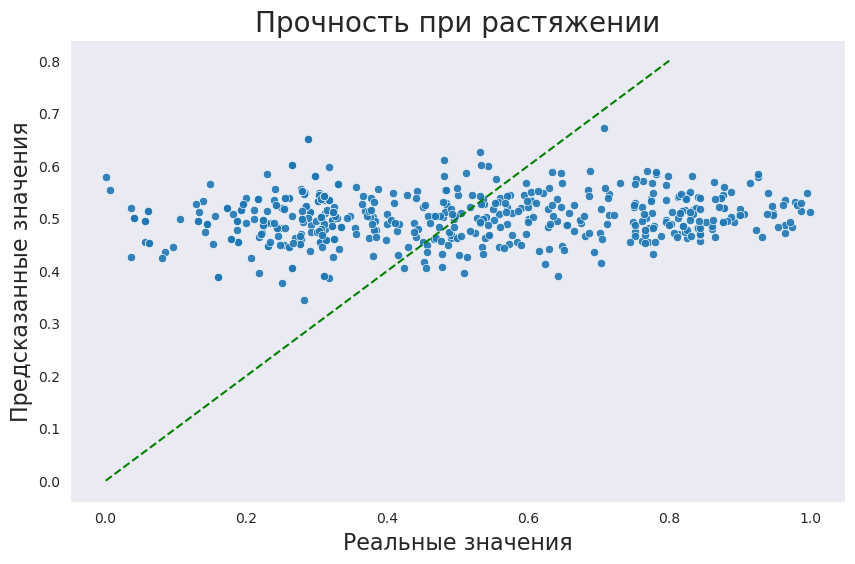

In [18]:
#сделаем визуализацию
def model_plot():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=np.ravel(y_test), y=np.ravel(y_pred), alpha=0.9)
    line_x, line_y = np.arange(0.0, 1.0, 0.2),np.arange(0.0, 1.0, 0.2)
    plt.plot(line_x, line_y, 'g--')
    plt.title("Прочность при растяжении", fontsize=20)
    plt.xlabel('Реальные значения', fontsize=16)
    plt.ylabel('Предсказанные значения', fontsize=16)
    plt.show()

model_plot()

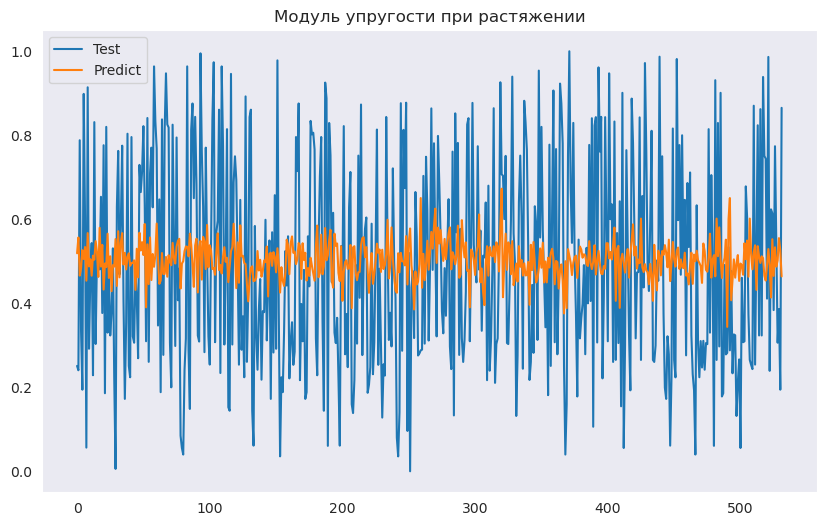

In [19]:
#Визуализация предсказанных значений целевой переменной
def pred_plot(y_test, y_pred):
  plt.figure(figsize=(10, 6))
  plt.title('Модуль упругости при растяжении')
  plt.plot(y_test.to_numpy(), label='Test')
  plt.plot(y_pred, label='Predict')
  plt.legend(loc='best')
pred_plot(y_test, y_pred)

In [20]:
ridge = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
ridge.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.250888,0.240548,0.788161,0.334513,0.194276,0.898532,0.604224,0.056391,0.914206,0.291730,0.464948,0.543305,0.228677,0.831282,0.303135,0.516488,0.490294,0.480545,0.653498,0.376842
Предсказанные,0.519078,0.556555,0.465879,0.482720,0.526305,0.505513,0.533884,0.453823,0.567100,0.487785,0.504913,0.465685,0.513389,0.503759,0.547989,0.521051,0.462786,0.579649,0.487489,0.538981


## Support Vector Regression

In [ ]:
#поиск гиперпараметров с перекрестной проверкой
def objective_svm(trial):
    params = {
        "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
        "tol": trial.suggest_float("tol", 0.001, 0.01, step=0.001,log=False),
        "C": trial.suggest_categorical("C", [0.1, 1, 10, 100, 1000]),
        "gamma": trial.suggest_categorical("gamma", [1, 0.1, 0.01, 0.001, 0.0001])
    }
    
    score = cross_val_score(SVR(**params),
                            X_train, y_train, cv=cv, scoring='r2', n_jobs=-1).mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective_svm, n_trials=25, n_jobs=-1)

In [22]:
study.best_params

{'kernel': 'rbf', 'tol': 0.006, 'C': 10, 'gamma': 1}

In [23]:
svr = SVR(**study.best_params)
svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          Support Vector Regression  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          Support Vector Regression  

R2 score: 0.44867902049809194 
Mean Absolute Error: 0.1397613842312126
Root Mean Squared Error: 0.18510649892896977
Max Error: 0.6860671094858855


In [24]:
#сохраним результаты проверки протестированных моделей
r2_scores["SVR"] = r2
mae_scores["SVR"] = mae
rmse_scores["SVR"] = rmse
max_scores["SVR"] = max

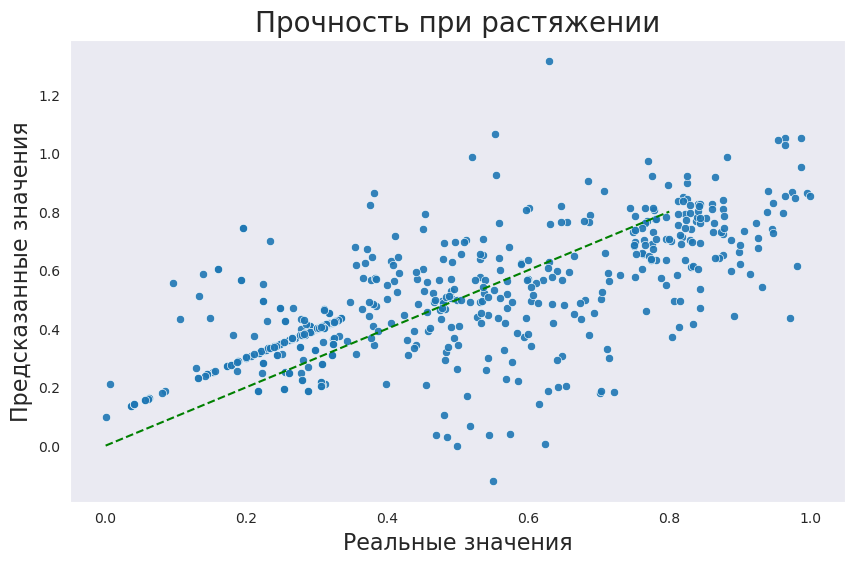

In [25]:
#сделаем визуализацию
model_plot()

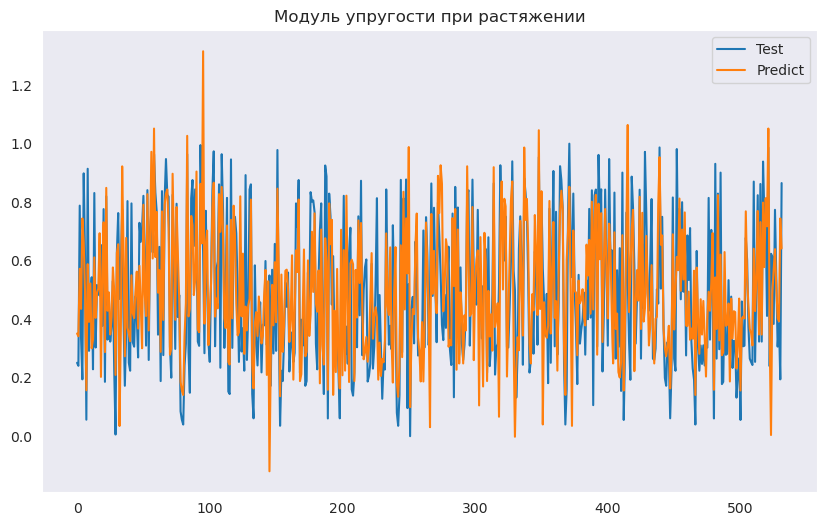

In [26]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [27]:
svr = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
svr.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.250888,0.240548,0.788161,0.334513,0.194276,0.898532,0.604224,0.056391,0.914206,0.291730,0.464948,0.543305,0.228677,0.831282,0.303135,0.516488,0.490294,0.480545,0.653498,0.376842
Предсказанные,0.350941,0.341527,0.572306,0.435144,0.744547,0.660854,0.493365,0.156752,0.588183,0.390802,0.522268,0.300572,0.330540,0.611191,0.404437,0.489596,0.504911,0.693801,0.202655,0.565102


## KNeighborsRegressor

In [28]:
#гиперпараметры для поиска по сетке
params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          }

In [29]:
#поиск гиперпараметров с перекрестной проверкой
estimator = KNeighborsRegressor()
grid = grid_search(estimator,params)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [30]:
grid.best_params_

{'algorithm': 'auto',
 'metric': 'minkowski',
 'n_neighbors': 9,
 'weights': 'distance'}

In [32]:
neighbors = KNeighborsRegressor(** grid.best_params_,n_jobs=-1)
neighbors.fit(X_train, y_train)
y_pred = neighbors.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          KNeighborsRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          KNeighborsRegressor  

R2 score: 0.6805573495233324 
Mean Absolute Error: 0.08267991617022533
Root Mean Squared Error: 0.14090157818453822
Max Error: 0.6124271062426593


In [33]:
#сохраним результаты проверки протестированных моделей
r2_scores["K-neighbors"] = r2
mae_scores["K-neighbors"] = mae
rmse_scores["K-neighbors"] = rmse
max_scores["K-neighbors"] = max

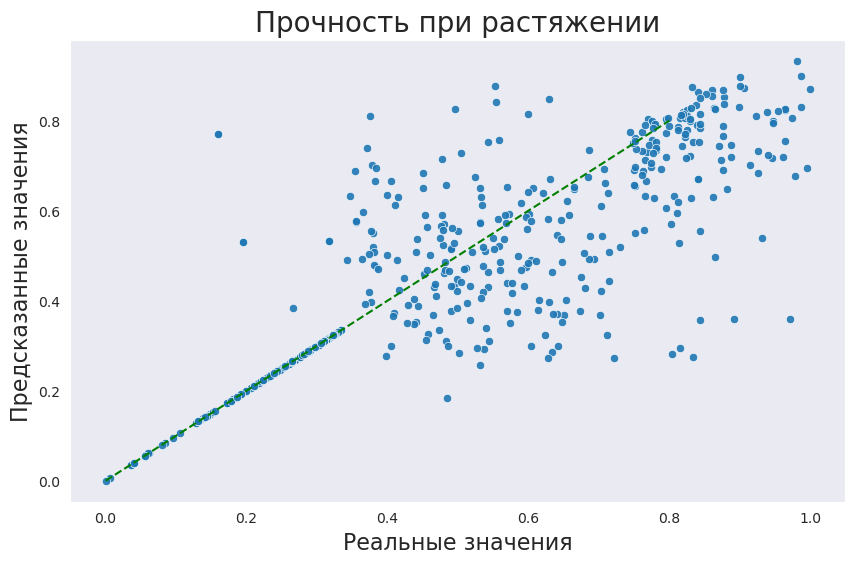

In [34]:
#сделаем визуализацию
model_plot()

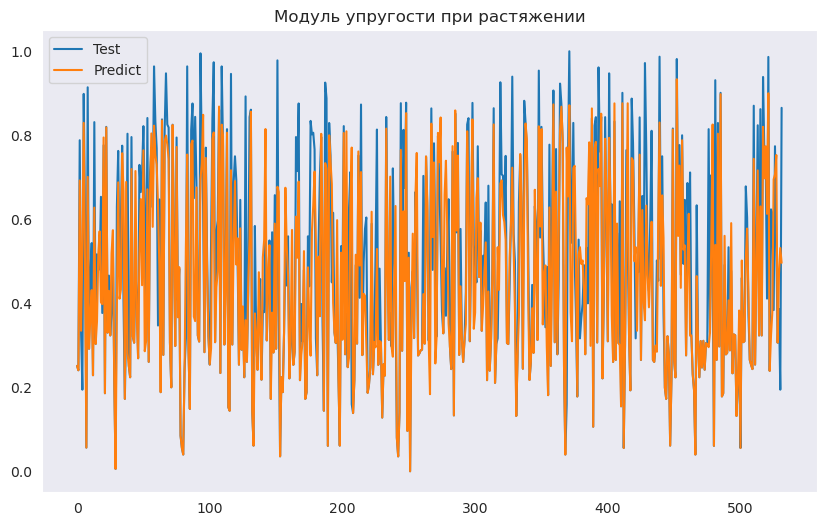

In [35]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [36]:
k_neighbors = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
k_neighbors.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.250888,0.240548,0.788161,0.334513,0.194276,0.898532,0.604224,0.056391,0.914206,0.29173,0.464948,0.543305,0.228677,0.831282,0.303135,0.516488,0.490294,0.480545,0.653498,0.376842
Предсказанные,0.250888,0.240548,0.692368,0.334513,0.531548,0.829502,0.489998,0.056391,0.700874,0.29173,0.368751,0.431322,0.228677,0.627785,0.303135,0.356497,0.517150,0.571486,0.402555,0.397945


## RandomForestRegressor

In [ ]:
#поиск гиперпараметров с перекрестной проверкой
def objective_randomforest(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, step=1, log=False),
        "max_depth": trial.suggest_int("max_depth", 10, 100, 10),
        "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2', None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }
    
    score = cross_val_score(RandomForestRegressor(**params),
                            X_train, y_train, cv=cv, scoring='r2', n_jobs=-1).mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective_randomforest, n_trials=25, n_jobs=-1)

In [38]:
study.best_params

{'n_estimators': 250,
 'min_samples_split': 5,
 'max_depth': 100,
 'max_features': 'sqrt',
 'bootstrap': False}

In [39]:
forest = RandomForestRegressor(**study.best_params, n_jobs=-1)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          RandomForestRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          RandomForestRegressor  

R2 score: 0.7876789325633805 
Mean Absolute Error: 0.07499407086545161
Root Mean Squared Error: 0.11487246794721861
Max Error: 0.48691481832168565


In [40]:
#сохраним результаты проверки протестированных моделей
r2_scores["RandomForest"] = r2
mae_scores["RandomForest"] = mae
rmse_scores["RandomForest"] = rmse
max_scores["RandomForest"] = max

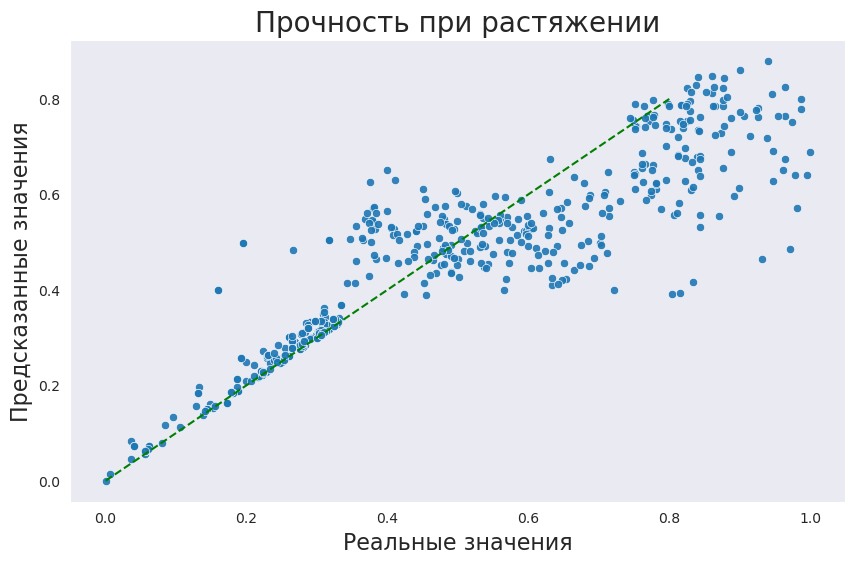

In [41]:
#сделаем визуализацию
model_plot()

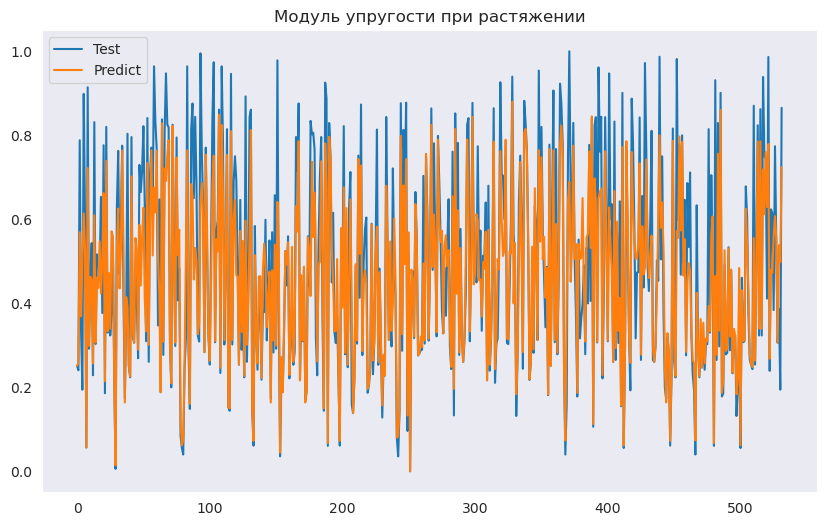

In [42]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [43]:
random_forest = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
random_forest.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.250888,0.240548,0.788161,0.334513,0.194276,0.898532,0.604224,0.056391,0.914206,0.291730,0.464948,0.543305,0.228677,0.831282,0.303135,0.516488,0.490294,0.480545,0.653498,0.376842
Предсказанные,0.251154,0.258055,0.569165,0.368676,0.497686,0.614023,0.527491,0.056391,0.721845,0.298344,0.463054,0.454776,0.256841,0.609637,0.306389,0.461429,0.436525,0.547574,0.423303,0.499651


## ExtraTreesRegressor

In [ ]:
#поиск гиперпараметров с перекрестной проверкой
def objective_extratree(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, step=1, log=False),
        "max_depth": trial.suggest_int("max_depth", 10, 100, 10),
        "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2', None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }
    
    score = cross_val_score(ExtraTreesRegressor(**params),
                            X_train, y_train, cv=cv, scoring='r2', n_jobs=-1).mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective_extratree, n_trials=25, n_jobs=-1)

In [45]:
study.best_params


{'n_estimators': 650,
 'min_samples_split': 2,
 'max_depth': 100,
 'max_features': 'log2',
 'bootstrap': False}

In [46]:
extra = ExtraTreesRegressor(**study.best_params, n_jobs=-1)
extra.fit(X_train, y_train)

y_pred = extra.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          ExtraTreesRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          ExtraTreesRegressor  

R2 score: 0.8026603076350324 
Mean Absolute Error: 0.06783716905473025
Root Mean Squared Error: 0.11074563829991795
Max Error: 0.46994517691383964


In [47]:
#сохраним результаты проверки протестированных моделей
r2_scores["ExtraTreesRegressor"] = r2
mae_scores["ExtraTreesRegressor"] = mae
rmse_scores["ExtraTreesRegressor"] = rmse
max_scores["ExtraTreesRegressor"] = max

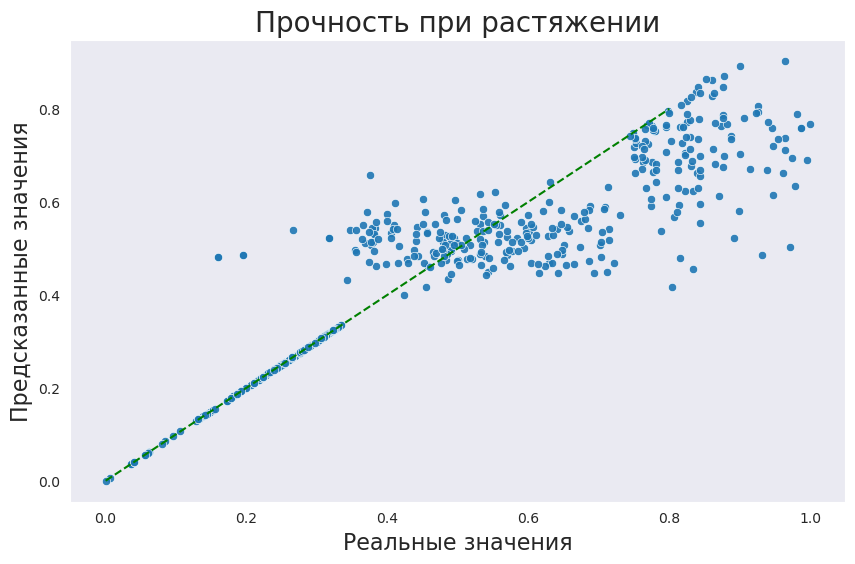

In [48]:
#сделаем визуализацию
model_plot()

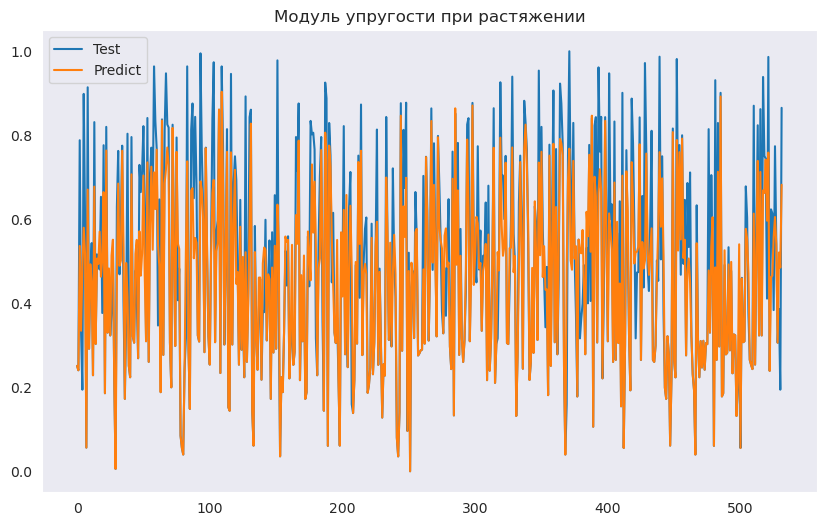

In [49]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [50]:
extra_tree = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
extra_tree.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.250888,0.240548,0.788161,0.334513,0.194276,0.898532,0.604224,0.056391,0.914206,0.29173,0.464948,0.543305,0.228677,0.831282,0.303135,0.516488,0.490294,0.480545,0.653498,0.376842
Предсказанные,0.250888,0.240548,0.536447,0.334513,0.484924,0.579907,0.518018,0.056391,0.670665,0.29173,0.492945,0.448900,0.228677,0.677758,0.303135,0.506450,0.493588,0.570619,0.463413,0.506721


## XGBRegressor

In [51]:
#поиск гиперпараметров с перекрестной проверкой
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, 50),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.05,0.10,0.15,0.20,0.25,0.30]),
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1, log=False),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step=1, log=False),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5, step=0.1, log=False),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, step=0.1, log=False),
        "random_state": trial.suggest_int("random_state", 1, 10, step=1, log=False),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 3, step=1, log=False),
    }
    
    score = cross_val_score(XGBRegressor(**params),
                            X_train, y_train, cv=cv, scoring='r2', n_jobs=-1).mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective_xgb, n_trials=25, n_jobs=-1)

In [52]:
study.best_params

{'n_estimators': 100,
 'learning_rate': 0.25,
 'max_depth': 8,
 'min_child_weight': 1,
 'gamma': 0.0,
 'colsample_bytree': 0.6,
 'random_state': 9,
 'scale_pos_weight': 2}

In [54]:
xgb = XGBRegressor(**study.best_params,n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

r2 = r2_score(y_test, y_pred , force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          XGBRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          XGBRegressor  

R2 score: 0.7613378916823423 
Mean Absolute Error: 0.07413120651129985
Root Mean Squared Error: 0.12178986346567716
Max Error: 0.536122545601416


In [55]:
#сохраним результаты проверки протестированных моделей
r2_scores["XGBoost"] = r2
mae_scores["XGBoost"] = mae
rmse_scores["XGBoost"] = rmse
max_scores["XGBoost"] = max

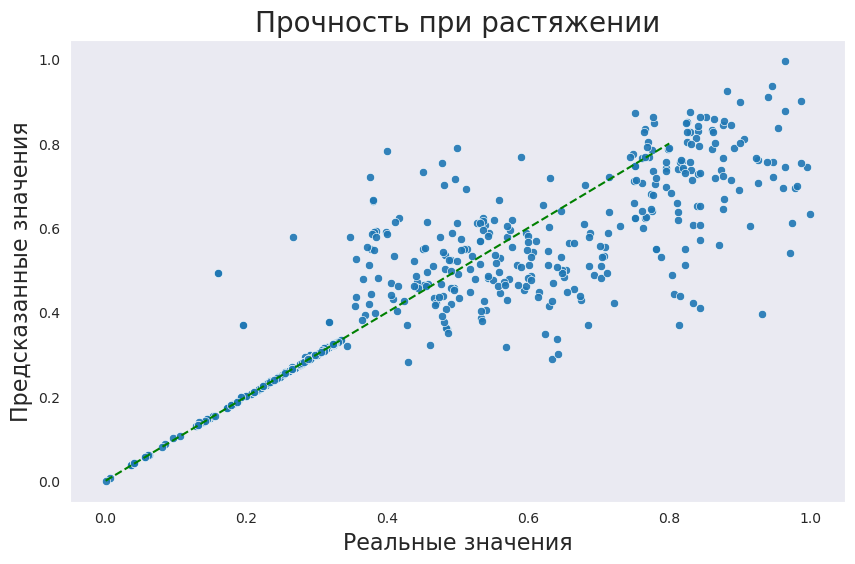

In [56]:
#сделаем визуализацию
model_plot()

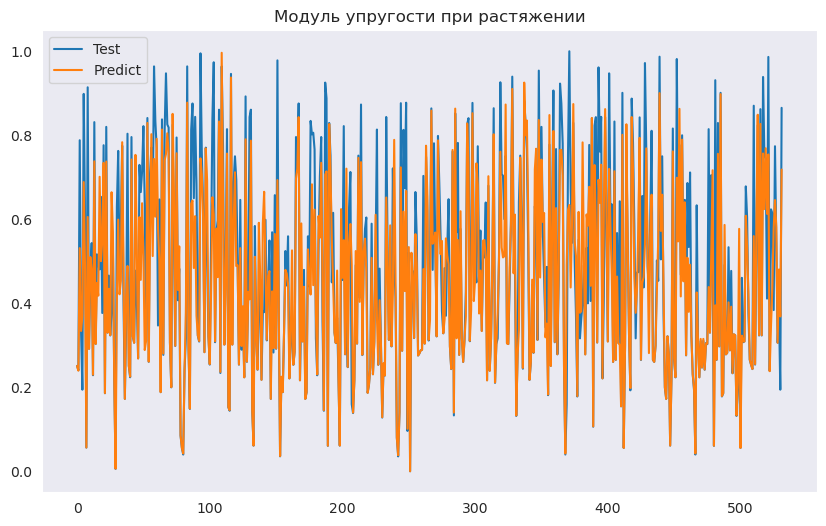

In [57]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [58]:
xgboost = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
xgboost.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.250888,0.240548,0.788161,0.334513,0.194276,0.898532,0.604224,0.056391,0.914206,0.291730,0.464948,0.543305,0.228677,0.831282,0.303135,0.516488,0.490294,0.480545,0.653498,0.376842
Предсказанные,0.250642,0.239689,0.531306,0.333954,0.368699,0.688593,0.486420,0.056561,0.605412,0.291366,0.510145,0.479917,0.229893,0.737919,0.303105,0.448151,0.418198,0.701159,0.500320,0.550174


## CatBoostRegressor

In [59]:
#поиск гиперпараметров с перекрестной проверкой
def objective_catboost(trial):
    params = {
        "learning_rate": trial.suggest_categorical("learning_rate", [0.001,0.01, 0.02, 0.03, 0.1, 1.0]),
        "l2_leaf_reg": trial.suggest_discrete_uniform("l2_leaf_reg", 1, 9, 2),
        "depth": trial.suggest_categorical("depth", [2,4,6,8,10])
        
    }
    score = cross_val_score(CatBoostRegressor(**params,verbose=0,iterations=100),
                            X_train, y_train, cv=cv, scoring='r2', n_jobs=-1).mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=25, n_jobs=-1)

In [60]:
study.best_params

{'learning_rate': 0.1, 'l2_leaf_reg': 3.0, 'depth': 10}

In [61]:
cat = CatBoostRegressor(**study.best_params,thread_count=-1 )
cat.fit(X_train, y_train, verbose=0, early_stopping_rounds = 30, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [62]:
y_pred = cat.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

In [63]:
print("          CatBoostRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          CatBoostRegressor  

R2 score: 0.8056889377540318 
Mean Absolute Error: 0.06645111541182064
Root Mean Squared Error: 0.10989252952530898
Max Error: 0.4829933313679313


In [64]:
#сохраним результаты проверки протестированных моделей
r2_scores["CatBoost"] = r2
mae_scores["CatBoost"] = mae
rmse_scores["CatBoost"] = rmse
max_scores["CatBoost"] = max

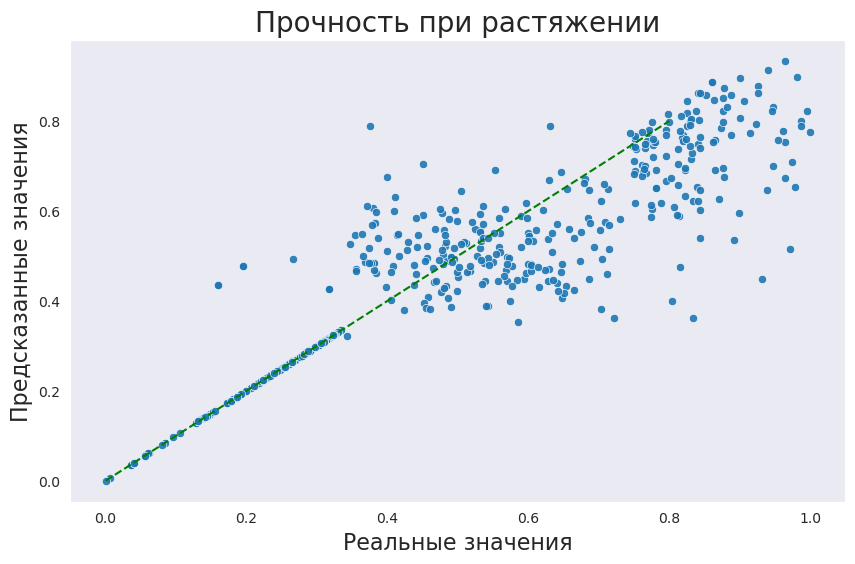

In [65]:
#сделаем визуализацию
model_plot()

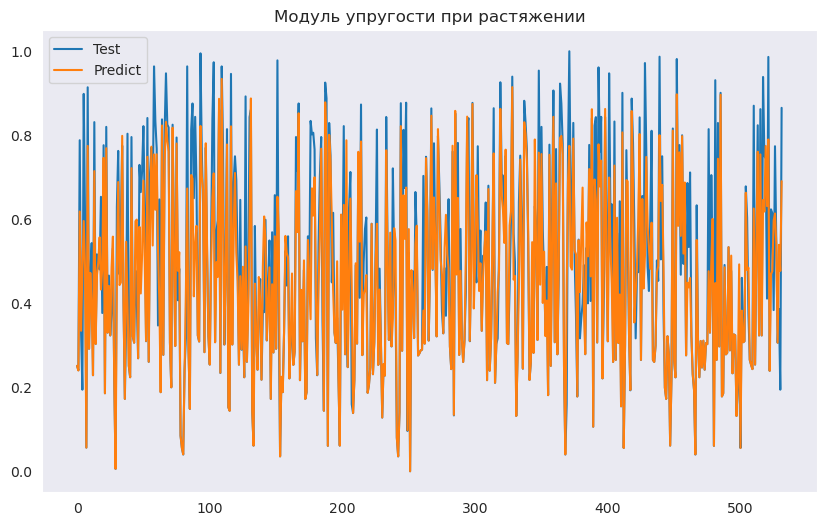

In [66]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [67]:
catboost = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
catboost.tail(20).T

,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531
Актуальные,0.535226,0.823792,0.323379,0.862163,0.323379,0.938816,0.750843,0.744287,0.411111,0.986535,0.239119,0.623552,0.614196,0.383815,0.773885,0.542739,0.306137,0.386165,0.194276,0.865316
Предсказанные,0.539259,0.760876,0.323451,0.754434,0.323451,0.646008,0.618414,0.774541,0.631314,0.790003,0.239351,0.469534,0.476367,0.597028,0.613778,0.540709,0.306139,0.539082,0.477088,0.690671


## VotingRegressor

In [ ]:
vr = VotingRegressor([('e', extra), ('c', cat)])
vr.fit(X_train, y_train)
y_pred = vr.predict(X_test)

r2 = r2_score(y_test, y_pred , force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

In [83]:
print("          VotingRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          VotingRegressor  

R2 score: 0.8099761936806442 
Mean Absolute Error: 0.06649427069131211
Root Mean Squared Error: 0.10867343977329065
Max Error: 0.46643583525399357


In [84]:
#сохраним результаты проверки протестированных моделей
r2_scores["VotingRegressor"] = r2
mae_scores["VotingRegressor"] = mae
rmse_scores["VotingRegressor"] = rmse
max_scores["VotingRegressor"] = max

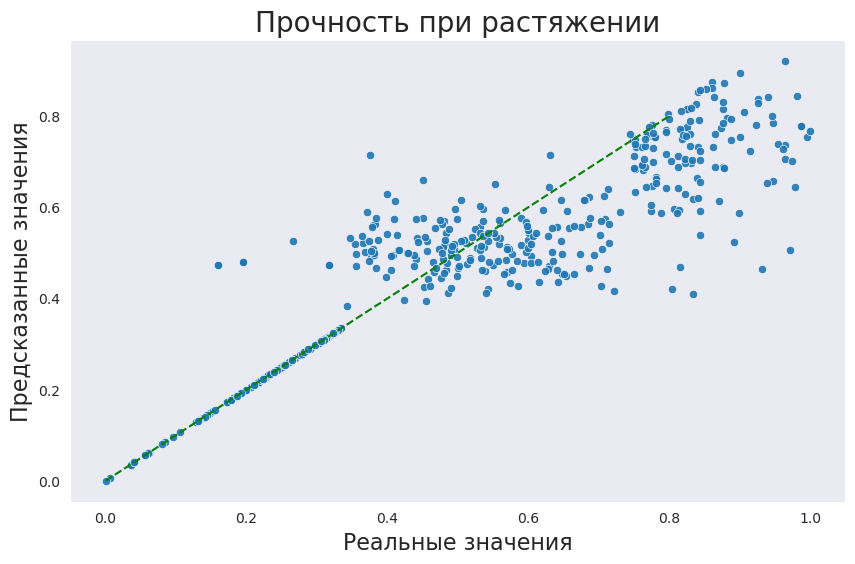

In [85]:
#сделаем визуализацию
model_plot()

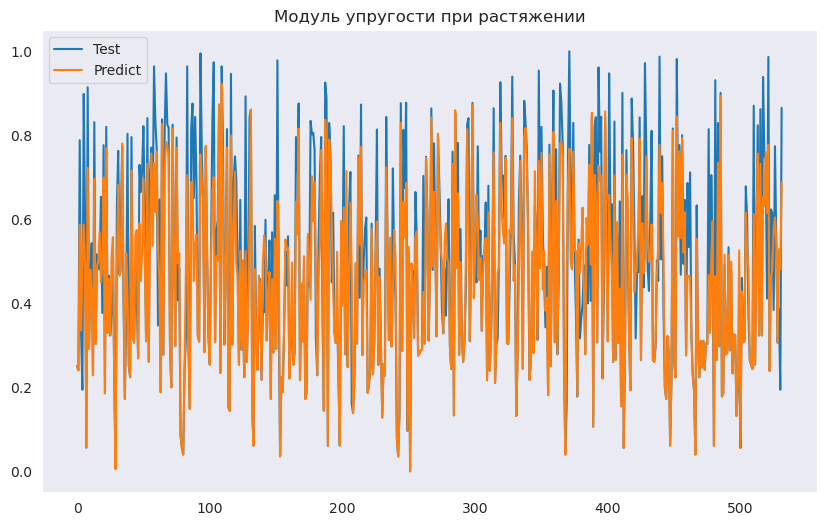

In [86]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [87]:
voting = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
voting.tail(20).T

,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531
Актуальные,0.535226,0.823792,0.323379,0.862163,0.323379,0.938816,0.750843,0.744287,0.411111,0.986535,0.239119,0.623552,0.614196,0.383815,0.773885,0.542739,0.306137,0.386165,0.194276,0.865316
Предсказанные,0.537375,0.756368,0.323415,0.732127,0.323415,0.653041,0.632310,0.759774,0.614518,0.777556,0.239235,0.459497,0.479210,0.576058,0.604650,0.542382,0.306138,0.528664,0.480013,0.687562


In [88]:
scores= [r2_scores, mae_scores, rmse_scores, max_scores]

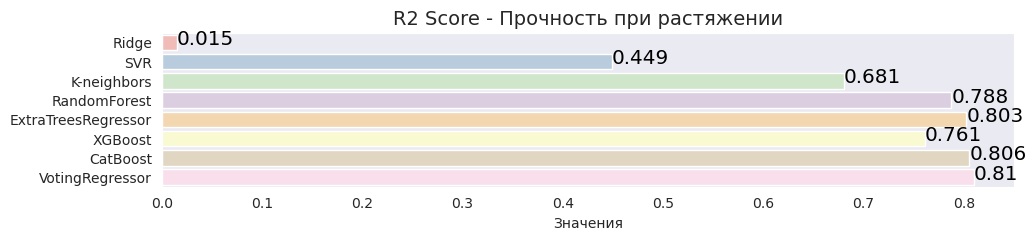

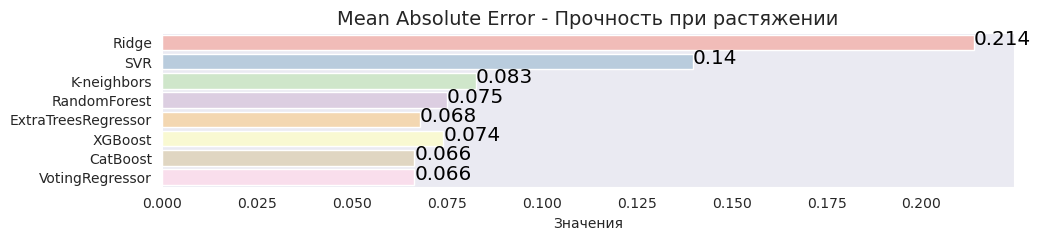

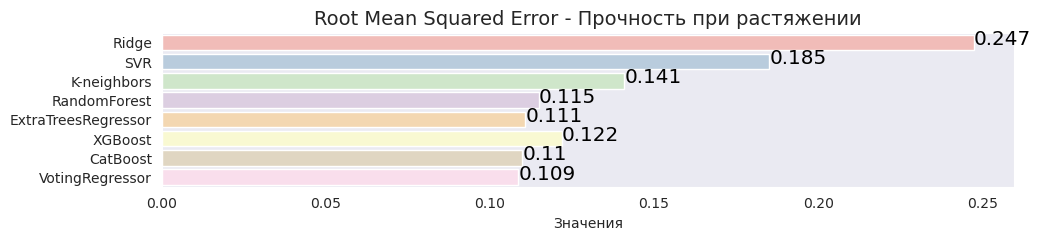

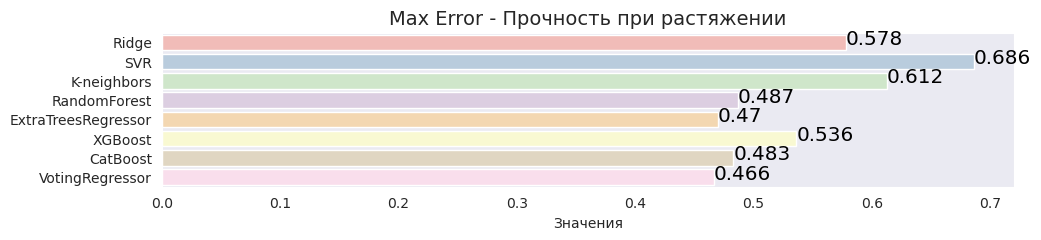

In [90]:
#визуализируем  метрики
titles = ['R2 Score - Прочность при растяжении',
          'Mean Absolute Error - Прочность при растяжении',
          'Root Mean Squared Error - Прочность при растяжении',
          'Max Error - Прочность при растяжении']


for i in range(len(scores)):
    plt.figure(figsize=(11, 2))
    render = sns.barplot(x=list(scores[i].values()), y=list(
        scores[i].keys()), palette="Pastel1")
    plt.title(titles[i], fontsize=14)
    plt.xlabel("Значения", fontsize=10)
    # plt.ylabel("Модель", fontsize=14)

   
    for j in render.patches:
        if not np.math.isnan(j.get_width()):
            x = j.get_width() - render.patches[0].get_width()*0
            y = j.get_y() + j.get_height() - 0.3
            value = round(j.get_width(), 3)
            render.text(x, y, value, ha="left", color='black', size='x-large')
    plt.show()

## Сохранение лучшей модели

In [91]:
with open('strength.pkl', 'wb') as file:
    pickle.dump(vr, file)